# Trabalho Prático - Introdução À Computação Visual

Neste trabalho prático foi implementado um pipeline para compressão de imagens baseado no JPEG. Inicialmente realizamos a centralização dos píxeis da imagem, i.e, subtraimos todos os valores dos pixeis por 128. Em seguida aplicamos a DCT(Discrete Cosine Transform) em blocos 8x8 da imagem, juntamente com a quantização, onde a matriz de quantização utilizada é a mesma do JPEG, vale a pena mencionar que nos casos em que a imagem não possui dimensões(altura e largura) multiplas de 8, é então aplicado um "padding" na imagem para garantir que esse processo ocorra sem problemas.

O próximo passo consite em aplicar um caminhamento em zig-zag em cada um dos blocos 8x8 da matriz obtida após aplicar a DCT e a quantização, tal processa permite concentrar os valores mais altos no ínicio do vetor referente àquele bloco e valores pequenos no final desse vetor.

A partir da organização dos vetores obtida, como descrito anteriormente, podemos utilizar a redundância interpixel utilizando a função preditora: $$\hat{f}_{n}(x,y) = (x-1,y)$$ . Em seguida é aplicado o Comprimento de Corrida que produz tuplas do tipo (#repetição,valor) para cada um dos blocos.

Por fim, obtém-se a frequência de ocorrência de cada uma das tuplas e então através do método de Huffman é gerada um codificação binária para cada uma delas.


In [245]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

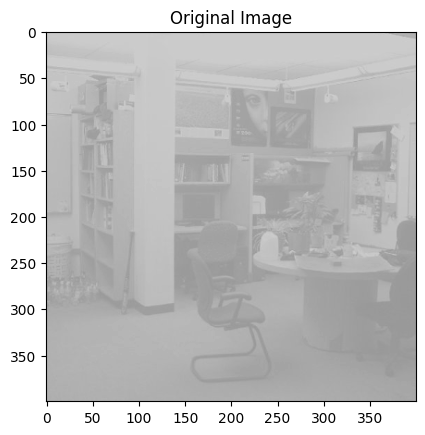

(400, 400)


In [246]:
# Load the image in grayscale
img_path = '/content/unequal.pgm'
original_image = cv2.imread(img_path, 0).astype(float)

# Show the original image
plt.imshow(original_image, cmap='gray', clim=(0, 255))
plt.title('Original Image')
plt.show()

print(original_image.shape)

## Codificação

### DCT e Quantização

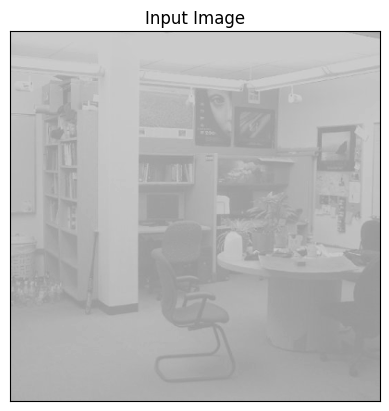

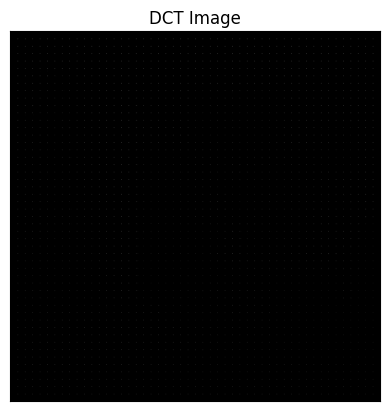

[[37. -0.  0. ...  0. -0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0.  0. ... -0.  0.  0.]
 [ 0. -0. -0. ...  0. -0. -0.]
 [ 0. -0. -0. ... -0.  0. -0.]]


In [247]:
def encoding(image):
  # Making a copy of the image
  image = image.copy()
  image = image.astype(float)
  # Define Quantization Matrix
  QM = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]]).astype(float)

  #List of DC components
  DC_components = []

  # Center the pixel values
  image -= 128

  X, Y = image.shape
  step = QM.shape[0]

  # Initializing padding_x and padding_y
  padding_x = 0
  padding_y = 0

  # Apply padding if necessary
  if X % step != 0:
      padding_x = step - (X % step)
      image = np.pad(image, ((0, padding_x), (0, 0)), mode='constant')
      X = image.shape[0]

  if Y % step != 0:
      padding_y = step - (Y % step)
      image = np.pad(image, ((0, 0), (0, padding_y)), mode='constant')
      Y = image.shape[1]

  # Matrix to store results
  DCT = np.zeros_like(image)

  # Apply DCT, Quantization, Dequantization, and IDCT block by block
  for i in range(0, X, step):
      for j in range(0, Y, step):
          # Extract 8x8 block from the original image
          block = image[i:i+step, j:j+step]

          # Apply DCT to the block
          dct_block = cv2.dct(block)

          #Saving the DC component
          DC = dct_block[0,0]
          DC_components.append(DC)

          # Quantize the DCT coefficients
          quant_block = np.round(dct_block / QM)

          # Store the quantized DCT block in the DCT matrix
          DCT[i:i+step, j:j+step] = quant_block

  return DCT,DC_components,step,padding_x, padding_y

DCT, DC_components, step, padding_x, padding_y = encoding(original_image)

# Display the images
plt.imshow(original_image, cmap='gray', clim=(0, 255))
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.imshow(DCT, cmap='gray', clim=(0, 255))
plt.title('DCT Image'), plt.xticks([]), plt.yticks([])
plt.show()

print(DCT)

### Zig-Zag


In [248]:
def zigzag(DCT):
  # implementing zig-zag
  i = 0
  j = 0
  m,n = DCT.shape
  zig_zag = []

  # Execute zig-zag until the last element is reached
  while(i != m-1 or j != n-1):
    # Case 1: Element is in the first row
    if(i==0):
      zig_zag.append(DCT[i,j])
      # Move to the right
      j += 1
      # Proceed to go down until an element in the first column or the last row is reached
      while(i != m-1 and j != 0):
        zig_zag.append(DCT[i,j])
        i += 1
        j -= 1

    # Case 2: Element is in the last row
    if(i==m-1):
      # Move to the right
      zig_zag.append(DCT[i,j])
      j += 1
      # Proceed to go up until the last column or the first row is reached
      while(i != 0 and j != n-1):
        zig_zag.append(DCT[i,j])
        i -= 1
        j += 1

    # Case 3: Element is in the first column
    if(j==0):
      # Move down
      zig_zag.append(DCT[i,j])
      i += 1
      # Proceed to go up until the last column or the first row is reached
      while(i != 0 and j != n-1):
        zig_zag.append(DCT[i,j])
        i -= 1
        j += 1

    # CAse 4: Element is in the last column
    if(j==n-1):
      # Move down
      zig_zag.append(DCT[i,j])
      # Check if all elements have already been added
      if len(zig_zag) == m*n:
        break
      i += 1
      # Proceed to go down until an element in the first column or the last row is reached
      while(i != m-1 and j != 0):
        zig_zag.append(DCT[i,j])
        i += 1
        j-= 1

  return zig_zag


# Apply the zig in 8x8 blocks of the DCT matrix
X,Y = DCT.shape
zigzag_list = []
for i in range(0, X, step):
    for j in range(0, Y, step):
        # Extract 8x8 block from the DCT matrix
        block = DCT[i:i+step, j:j+step]
        zig_zag = zigzag(block)
        zigzag_list.append(zig_zag)

zig_zag = np.array(zigzag_list)
print(zig_zag)
print(zig_zag.shape)



[[37. -0.  0. ... -0. -0.  0.]
 [38.  0.  0. ...  0.  0. -0.]
 [38.  0.  0. ...  0.  0.  0.]
 ...
 [19.  0. -0. ...  0.  0.  0.]
 [19. -0.  0. ...  0. -0.  0.]
 [19.  0.  0. ... -0.  0. -0.]]
(2500, 64)


### Redundância inter-pixel

In [249]:
def predictive_coding(array):
  # Create array of errors
  errors = np.zeros_like(array)
  # Copy the elements of the first column of array to the first column of errors
  errors[:,0] = array[:,0]
  # Compute error = f(x,y) - f(x-1,y)
  errors[:,1:] = np.diff(array)
  return errors

errors = predictive_coding(zig_zag)
print(errors)
print(errors.shape)

[[ 37. -37.   0. ...   0.   0.   0.]
 [ 38. -38.   0. ...   0.   0.  -0.]
 [ 38. -38.   0. ...   0.   0.   0.]
 ...
 [ 19. -19.  -0. ...   0.   0.   0.]
 [ 19. -19.   0. ...   0.  -0.   0.]
 [ 19. -19.   0. ...  -0.   0.  -0.]]
(2500, 64)


### Comprimento de Corrida

In [250]:
def RLE(errors):
  # Create a list for all of the rows in errors
  compressed = []

  for i in range(errors.shape[0]):
    list = []
    count = 1
    for j in range(1, errors.shape[1]):
      # If value is equal the previous increase count by one
      if errors[i,j] == errors[i,j-1]:
        count += 1
      # Else append the tuple (count,value) to the list and restar the count
      else:
        list.append((count, int(errors[i,j-1])))
        count = 1

    # Add the last element
    list.append((count, int(errors[i,-1])))
    compressed.append(list)
  return compressed


compressed = RLE(errors)
print(compressed)

[[(1, 37), (1, -37), (62, 0)], [(1, 38), (1, -38), (62, 0)], [(1, 38), (1, -38), (62, 0)], [(1, 38), (1, -38), (62, 0)], [(1, 38), (1, -38), (62, 0)], [(1, 38), (1, -38), (62, 0)], [(1, 38), (1, -38), (62, 0)], [(1, 38), (1, -38), (62, 0)], [(1, 38), (1, -38), (62, 0)], [(1, 38), (1, -38), (62, 0)], [(1, 38), (1, -38), (62, 0)], [(1, 38), (1, -38), (62, 0)], [(1, 38), (1, -38), (62, 0)], [(1, 37), (1, -37), (62, 0)], [(1, 37), (1, -37), (1, -1), (1, 1), (60, 0)], [(1, 36), (1, -36), (1, -1), (1, 1), (60, 0)], [(1, 37), (1, -37), (1, 0), (1, 1), (1, -1), (59, 0)], [(1, 37), (1, -37), (62, 0)], [(1, 38), (1, -38), (62, 0)], [(1, 38), (1, -38), (62, 0)], [(1, 37), (1, -36), (1, -2), (1, 0), (1, 2), (1, -2), (1, 1), (1, -1), (1, 2), (1, -2), (2, 1), (1, -2), (1, 1), (50, 0)], [(1, 35), (1, -36), (1, -3), (1, 2), (2, 1), (3, 0), (1, -1), (1, 1), (53, 0)], [(1, 37), (1, -38), (1, 0), (1, 1), (1, -1), (1, 1), (2, 0), (1, -1), (1, 0), (1, 1), (53, 0)], [(1, 38), (1, -38), (62, 0)], [(1, 38), (

### Obtendo a frequência de ocorrência das tuplas

In [251]:
def get_frequency(compressed):

  # Getting the frequency of each tuple (count,value)
  freq = {}
  for block in compressed:
    for tuple in block:
     if tuple in freq:
      freq[tuple] += 1
     else:
      freq[tuple] = 1

  # Sorting the dictionary by value
  return freq

freq = get_frequency(compressed)
print(freq)
freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)
print(freq)

{(1, 37): 78, (1, -37): 73, (62, 0): 1070, (1, 38): 106, (1, -38): 108, (1, -1): 1973, (1, 1): 2051, (60, 0): 216, (1, 36): 75, (1, -36): 82, (1, 0): 758, (59, 0): 67, (1, -2): 647, (1, 2): 616, (2, 1): 160, (50, 0): 50, (1, 35): 79, (1, -3): 246, (3, 0): 165, (53, 0): 145, (2, 0): 377, (1, -34): 83, (1, -5): 75, (1, 4): 141, (52, 0): 115, (1, 33): 80, (1, -32): 64, (1, -8): 17, (1, 5): 94, (1, 3): 291, (51, 0): 74, (1, 30): 74, (1, -29): 85, (1, 9): 5, (9, 0): 17, (40, 0): 4, (1, 26): 130, (1, -25): 132, (1, -6): 55, (1, 7): 19, (1, -4): 153, (7, 0): 37, (1, 23): 123, (1, -22): 104, (4, 0): 178, (1, 32): 81, (1, -33): 88, (1, 34): 71, (1, -35): 81, (57, 0): 126, (58, 0): 38, (61, 0): 92, (2, -1): 143, (56, 0): 119, (6, 0): 66, (54, 0): 71, (1, -7): 27, (8, 0): 29, (42, 0): 58, (43, 0): 32, (5, 0): 82, (48, 0): 84, (1, 31): 79, (1, -31): 90, (1, -30): 90, (49, 0): 42, (1, 6): 45, (3, -1): 11, (1, -24): 162, (1, 22): 108, (1, 28): 82, (44, 0): 19, (55, 0): 43, (2, 2): 19, (3, 1): 14, (1

### Huffman

In [252]:
class Node:
    def __init__(self, left=None, right=None):
        self.left = left
        self.right = right

    def get_children(self):
        return (self.left, self.right)

def building_huffman_tree(nodes):
    while len(nodes) > 1:
        # Pop the two nodes with the lowest frequency
        tuple1, frequency1 = nodes.pop()
        tuple2, frequency2 = nodes.pop()

        # Create a new parent node with these two nodes as children
        node = Node(tuple1, tuple2)

        # Add the new node back with its combined frequency
        nodes.append((node, frequency1 + frequency2))

        # Sort nodes by frequency in descending order for the next iteration
        nodes = sorted(nodes, key=lambda x: x[1], reverse=True)

    # Return only the root node (the first element in nodes)
    return nodes[0][0]  # Access the node part of the tuple

def huffman_coding(node, binString=''):
    # Verify if the node is a tuple, if so we reached a leaf
    if isinstance(node, tuple):
        return {node: binString}
    # Get children of the node
    (l, r) = node.get_children()
    d = {}
    # Obtain the binary code recursively
    d.update(huffman_coding(l, binString + '0'))
    d.update(huffman_coding(r, binString + '1'))
    return d

nodes = freq
huffman_tree = building_huffman_tree(nodes)
huffman_codes = huffman_coding(huffman_tree)
huffman_codes = dict(sorted(huffman_codes.items(), key=lambda item: len(item[1])))

# Show huffman coding for every tuplle
for symbol, code in huffman_codes.items():
    print(f"{symbol}: {code}")

(1, -1): 011
(1, 1): 100
(1, 0): 0001
(62, 0): 1011
(2, 0): 00100
(1, 2): 11011
(1, -2): 11101
(4, 0): 000010
(60, 0): 010000
(1, -3): 010101
(1, 3): 110010
(1, 16): 0000000
(1, 17): 0000001
(1, -33): 0000010
(1, -30): 0000011
(1, -31): 0000110
(61, 0): 0000111
(1, 5): 0010100
(1, 27): 0010101
(1, -18): 0010111
(1, -17): 0011000
(1, -26): 0011001
(1, -16): 0011011
(1, -22): 0011100
(1, 38): 0011101
(1, 22): 0011111
(1, -38): 0100010
(52, 0): 0100100
(1, 18): 0100110
(56, 0): 0100111
(1, -23): 0101000
(1, -20): 0101001
(1, 23): 0101100
(1, -21): 0101110
(57, 0): 0101111
(1, 20): 1010000
(1, -19): 1010010
(1, 26): 1010011
(1, 21): 1010100
(1, -25): 1010101
(1, 25): 1010111
(1, 4): 1100000
(2, -1): 1100010
(53, 0): 1100110
(1, 19): 1100111
(1, -4): 1101011
(1, 24): 1110000
(2, 1): 1110011
(1, -24): 1111001
(3, 0): 1111100
(1, 13): 00101101
(50, 0): 00110100
(1, 14): 00111100
(1, -13): 00111101
(1, -6): 01000110
(1, 15): 01001010
(42, 0): 01001011
(1, -14): 01011010
(1, -32): 10100010
(6, 

### Gerando Arquivo binário

In [253]:
import struct
import pickle

def generate_binary_file(compressed, file_name, height, width, huffman_codes):
    # Creating an empty binary string
    binary_string = ""

    # Transforming each tuple in compressed to its binary representation using the Huffman codes obtained
    # Concatenating binary codes in the Huffman in the binary string
    for block in compressed:
        for tuple in block:
            binary_string += huffman_codes[tuple]

    # Calculating the required padding
    padding_length = (8 - len(binary_string) % 8) % 8

    # Adding padding (0s) to the binary string
    binary_string += '0' * padding_length

    # Packing the shape (height, width) as binary
    shape_data = struct.pack('2I', height, width)  # '2I' means two unsigned integers (height, width)

    # Packing the padding length as binary
    padding_data = struct.pack('I', padding_length)  # 'I' means one unsigned integer for padding length

    # Packing padding_x and padding_y
    padding_img = struct.pack('2I', padding_x, padding_y)

    #Serializing the huffman code
    huffman_codes_serialized = pickle.dumps(huffman_codes)

    # Saving the padding information and the compressed binary data
    with open(f"{file_name}.bin", 'wb') as f:
        # First, write the padding info (4 bytes for padding length)
        f.write(padding_data)

        # Second, write the shape data (8 bytes for height and width)
        f.write(shape_data)

        # Third, write the padding_x and padding_y(8 bytes)
        f.write(padding_img)

        # Write the huffman codes
        f.write(struct.pack('I', len(huffman_codes_serialized)))  # Dictionary size in bytes
        f.write(huffman_codes_serialized)  # Serialized Huffman dictionary

        # Convert the binary string to byte data
        byte_data = int(binary_string, 2).to_bytes(len(binary_string) // 8, byteorder='big')

        # Write the actual compressed binary data
        f.write(byte_data)


generate_binary_file(compressed, "compressed_img", X, Y, huffman_codes)


## Decodificação

### Decodificando o arquivo binário

In [254]:
def decode_binary_file(file_name):
    with open(f"{file_name}.bin", 'rb') as f:
        # Read the padding size
        padding_data = f.read(4)
        padding_length = struct.unpack('I', padding_data)[0]

        # Read the height and width
        shape_data = f.read(8)
        height, width = struct.unpack('2I', shape_data)

        # Read the padding_x and padding_y
        padding_img = f.read(8)
        padding_x, padding_y = struct.unpack('2I', padding_img)

        # Read the size of the Huffman dictionary
        huffman_size_data = f.read(4)
        huffman_size = struct.unpack('I', huffman_size_data)[0]

        # Read the Huffman dictionary
        huffman_data = f.read(huffman_size)
        huffman_codes = pickle.loads(huffman_data)  # Deserialize the Huffman dictionary

        # Read the data
        compressed_data = f.read()

    # Convert the data into a binary string
    binary_string = ''.join(f'{byte:08b}' for byte in compressed_data)

    # Remover o padding final
    if padding_length > 0:
        binary_string = binary_string[:-padding_length]

    # Invert the Huffman dictionary in order to decode
    inverted_huffman_codes = {v: k for k, v in huffman_codes.items()}

    # Decoding the binary string
    decoded_tuples = []
    temp_code = ""
    for bit in binary_string:
        temp_code += bit
        if temp_code in inverted_huffman_codes:
            decoded_tuples.append(inverted_huffman_codes[temp_code])
            temp_code = ""  #Reset temp_code


    return height, width, decoded_tuples, padding_x, padding_y


height, width, decoded_data, padding_x, padding_y = decode_binary_file("compressed_img")
print(f"Height: {height}, Width: {width}")
print("Decoded Data:", decoded_data)


Height: 400, Width: 400
Decoded Data: [(1, 37), (1, -37), (62, 0), (1, 38), (1, -38), (62, 0), (1, 38), (1, -38), (62, 0), (1, 38), (1, -38), (62, 0), (1, 38), (1, -38), (62, 0), (1, 38), (1, -38), (62, 0), (1, 38), (1, -38), (62, 0), (1, 38), (1, -38), (62, 0), (1, 38), (1, -38), (62, 0), (1, 38), (1, -38), (62, 0), (1, 38), (1, -38), (62, 0), (1, 38), (1, -38), (62, 0), (1, 38), (1, -38), (62, 0), (1, 37), (1, -37), (62, 0), (1, 37), (1, -37), (1, -1), (1, 1), (60, 0), (1, 36), (1, -36), (1, -1), (1, 1), (60, 0), (1, 37), (1, -37), (1, 0), (1, 1), (1, -1), (59, 0), (1, 37), (1, -37), (62, 0), (1, 38), (1, -38), (62, 0), (1, 38), (1, -38), (62, 0), (1, 37), (1, -36), (1, -2), (1, 0), (1, 2), (1, -2), (1, 1), (1, -1), (1, 2), (1, -2), (2, 1), (1, -2), (1, 1), (50, 0), (1, 35), (1, -36), (1, -3), (1, 2), (2, 1), (3, 0), (1, -1), (1, 1), (53, 0), (1, 37), (1, -38), (1, 0), (1, 1), (1, -1), (1, 1), (2, 0), (1, -1), (1, 0), (1, 1), (53, 0), (1, 38), (1, -38), (62, 0), (1, 38), (1, -38), (6

### Expandindo código gerado pelo Comprimento de Corrida

In [255]:
import copy
def recovering_data_from_RLE(height,width,data):
  step = 8
  rows = (height // step) * (width // step)
  cols = step * step
  # Initialize matrix o shape height x width
  image = np.zeros((rows, cols))
  i = 0
  j = 0
  # Writing decoded values in the image
  while i < rows:
    j = 0
    while j < cols:
      # Get the first (count,value) tuple
      count, value = data.pop(0)
      # Create an array of size count where all entrie are the 'value'
      value_array = value * np.ones(count)
      # Insert arry in the image
      image[i,j:j+count] = value_array
      # increase j by cout
      j += count
      # If j equals the width skips to the next row
      if j == cols:
        i += 1

  return image
data = copy.deepcopy(decoded_data)
data_from_RLE = recovering_data_from_RLE(height,width, data)
print(data_from_RLE)
print(np.all(data_from_RLE == errors))

[[ 37. -37.   0. ...   0.   0.   0.]
 [ 38. -38.   0. ...   0.   0.   0.]
 [ 38. -38.   0. ...   0.   0.   0.]
 ...
 [ 19. -19.   0. ...   0.   0.   0.]
 [ 19. -19.   0. ...   0.   0.   0.]
 [ 19. -19.   0. ...   0.   0.   0.]]
True


### Recupereção dos dados a partir dos erros

In [256]:

def inv_predictive_coding(data):
  for j in range(1,data.shape[1]):
    data[:,j] += data[:,j-1]
  return data

data = copy.deepcopy(data_from_RLE)
data = inv_predictive_coding(data)
print(data)
print(data.shape)
print(np.all(data == zig_zag))

[[37.  0.  0. ...  0.  0.  0.]
 [38.  0.  0. ...  0.  0.  0.]
 [38.  0.  0. ...  0.  0.  0.]
 ...
 [19.  0.  0. ...  0.  0.  0.]
 [19.  0.  0. ...  0.  0.  0.]
 [19.  0.  0. ...  0.  0.  0.]]
(2500, 64)
True


### Recuperação dos dados a partir do zig_zag

In [257]:
def inv_zigzag(data,height,width):
  # List with the order where each elemnt in the block is acessed
  zigzag_indices = [
        0,  1,  5,  6, 14, 15, 27, 28,
        2,  4,  7, 13, 16, 26, 29, 42,
        3,  8, 12, 17, 25, 30, 41, 43,
        9, 11, 18, 24, 31, 40, 44, 53,
       10, 19, 23, 32, 39, 45, 52, 54,
       20, 22, 33, 38, 46, 51, 55, 60,
       21, 34, 37, 47, 50, 56, 59, 61,
       35, 36, 48, 49, 57, 58, 62, 63
    ]
  # Create matrix with the format of the original image
  new_data = np.zeros((height, width))
  # Defining the step size
  step = 8
  # Starting the row and column indices
  i = 0
  j = 0
  # Restoring the blocks of the image
  for row in range(data.shape[0]):
    # Reordering each row according to the 'zig_zag' indices
    block = data[row][zigzag_indices]
    block = block.reshape(8, 8)  # Reshape the block to 8x8
    new_data[i:i+step, j:j+step] = block
    j += step
    # If j equals the width skip to the next row
    if j == width:
      i += step
      j = 0

  return new_data


recovered_DCT = inv_zigzag(data,height,width)
print(recovered_DCT)
print(recovered_DCT.shape)
print(np.all(recovered_DCT == DCT))



[[37.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
(400, 400)
True


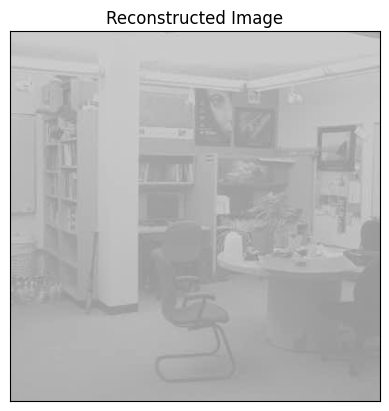

In [258]:
def inv_DCT(DCT,DC_components,padding_x,padding_y):

  QM = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]]).astype(float)

  #Decodification step
  IDCT = np.zeros_like(DCT)
  X,Y = DCT.shape
  pos = -1
  for i in range(0, X, step):
      for j in range(0, Y, step):
        # Dequantize the block
          quant_block = DCT[i:i+step, j:j+step]
          dequant_block = quant_block * QM

          pos += 1
          dequant_block[0,0] = DC_components[pos]
          # Apply IDCT to the dequantized block
          idct_block = cv2.idct(dequant_block)

          # Store the reconstructed block in the IDCT matrix
          IDCT[i:i+step, j:j+step] = idct_block

  # Removing padding
  IDCT = IDCT[:X-padding_x,:Y-padding_y]

  IDCT += 128
  # Clip values to the range [0, 255]
  IDCT = np.clip(IDCT, 0, 255)

  return IDCT

IDCT = inv_DCT(recovered_DCT,DC_components,padding_x,padding_y)


# Display the reconstructed image
plt.imshow(IDCT, cmap='gray', clim=(0, 255))
plt.title('Reconstructed Image'), plt.xticks([]), plt.yticks([])
plt.show()


## Calculando RMSE

In [259]:
error = np.sqrt(((original_image - IDCT) ** 2).mean())
print(f"RMSE = {error}")

RMSE = 1.9157770145300943


## Calculando Taxa de Compressão

In [260]:
import os
def compression_rate(original_size, compressed_size):
    return original_size/compressed_size

original_size = os.path.getsize(img_path)
compressed_size = os.path.getsize("/content/compressed_img.bin")

print(f"Taxa de compressão = {compression_rate(original_size, compressed_size)}")


Taxa de compressão = 11.762310745259445


## Calculando PSNR

In [261]:
def psnr(original, compressed):
  mse = np.mean((original_image - IDCT)** 2)
  max_pixel = 255.0
  val = (max_pixel**2 )/ mse
  return 10 * np.log10(val)

print(f"PSNR = {psnr(original_image, IDCT)}")

PSNR = 42.483904442793055
